In [1]:
from fastai.vision import *
from torchvision.models import vgg16_bn

In [2]:
from src.config import *
from src.models.superresgan import *
from src.data.make_dataset import *

### Look at training data

In [3]:
training_data = pd.read_csv(path_trainingset)

In [4]:
training_data.head()

,Image,Mask,is_validation
0,ISIC_0000031.jpg,ISIC_0000031_segmentation.png,True
1,ISIC_0010204.jpg,ISIC_0010204_segmentation.png,True
2,ISIC_0013089.jpg,ISIC_0013089_segmentation.png,True
3,ISIC_0014522.jpg,ISIC_0014522_segmentation.png,False
4,ISIC_0013767.jpg,ISIC_0013767_segmentation.png,False


## Pretraining

#### Create databunch

In [5]:
#change the format of the training_data dataframe to fit fastai.
img_paths = []

for i, row in training_data.iterrows():
    img_paths.append(path_img + '/' + row['Image'])

data = training_data.copy()
data['Image'] = img_paths
data.head()

,Image,Mask,is_validation
0,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0000031_segmentation.png,True
1,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0010204_segmentation.png,True
2,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0013089_segmentation.png,True
3,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0014522_segmentation.png,False
4,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,ISIC_0013767_segmentation.png,False


In [6]:
src = ImageImageList.from_df(data, path_mask, cols = 1).split_by_rand_pct(0.1, seed=42)

data_gen = (src.label_from_df(cols=0)
       .transform(get_transforms(), size=img_size, tfm_y=True)
       .databunch(bs=32).normalize(imagenet_stats, do_y=True))

data_gen.c = 3

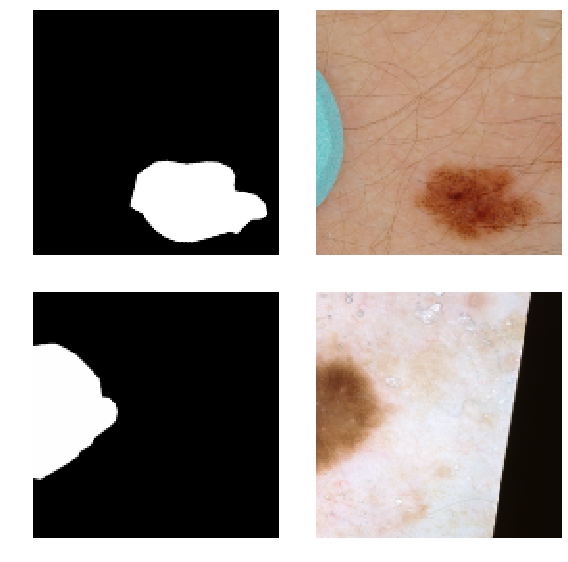

In [7]:
data_gen.show_batch(rows=2)

#### Generator

Create generator

In [8]:
arch = models.resnet34
t = data_gen.valid_ds[0][1].data
t = torch.stack([t,t])
base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

wd = 1e-3

In [9]:
generator = unet_learner(data_gen, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                 blur=True, norm_type=NormType.Weight, model_dir=Path('../../../models'))

Pretrain generator

In [10]:
gc.collect()

8020

In [11]:
generator.fit_one_cycle(2, slice(2e-3), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.395062,2.988693,0.519015,0.314179,0.333270,0.089532,0.681248,0.968491,0.082957,04:23
1,3.004128,2.666385,0.510048,0.302356,0.292244,0.078767,0.548787,0.857640,0.076543,04:23


In [12]:
generator.unfreeze()
generator.fit_one_cycle(2, slice(1e-5,2e-3), pct_start=0.9)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.675623,2.690004,0.504947,0.299760,0.297382,0.078704,0.541940,0.890636,0.076634,04:16
1,2.694554,2.605177,0.512231,0.300041,0.282718,0.076072,0.517239,0.841391,0.075485,04:23


Save generator

In [ ]:
generator.save('superres_generator', return_path=True)

Load generator

In [9]:
generator.load('superres_generator')
print('')

In [10]:
predict(data_gen.fix_dl.dataset.items, path_gen + '/pretrained_images', generator)

#### Critic

Create databunch

In [10]:
#TODO: set path to 'path_gen'
gen_data = os.listdir(path_gen + '/pretrained_images')
org_data = training_data['Image'].tolist()
classes = ['Real', 'Fake']

In [11]:
data_critic = label_data_critic(org_data, gen_data, path_img, path_gen + '/pretrained_images', classes)
data_critic.head()

,Filenames,label
0,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
1,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
2,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
3,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real
4,../data/raw/ISIC2018_Task1-2_Training_Input/IS...,Real


In [12]:
src = ImageList.from_df(path = Path(''), df=data_critic).split_by_rand_pct(0.1, seed=42)
ll = src.label_from_df('label')
data = (ll.transform(get_transforms(), size=128)
       .databunch(bs=32).normalize(imagenet_stats))
data.c = 3

Create critic

In [14]:
critic = Learner(data, gan_critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), wd=1e-3, model_dir=Path('../models'))

Train critic

In [32]:
critic.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.471849,0.334866,0.833807,02:21
1,0.250891,0.076566,0.971675,02:24
2,0.121569,0.045263,0.987411,02:27


Save critic

In [33]:
critic.save('superres_critic', return_path = True)

PosixPath('../models/superres_critic.pth')

Load critic

In [15]:
critic.load('superres_critic')
print()

## GAN model

Create GAN model

In [16]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
gan = GANLearner.from_learners(generator, critic, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                             opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd, model_dir=Path('../../../models'))
gan.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

Train GAN model

In [35]:
gan.fit(2, 1e-4)

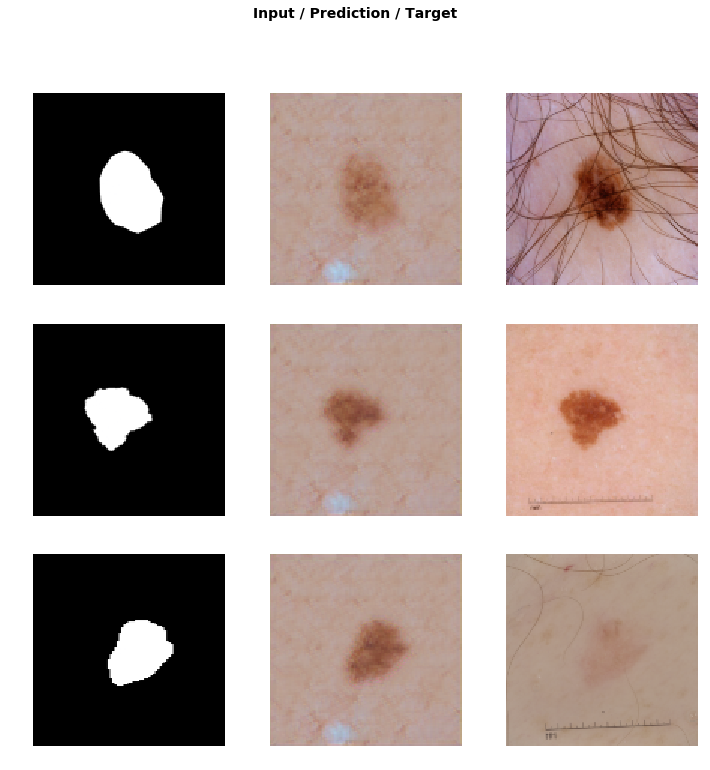

In [36]:
gan.show_results(rows=3)

Save model

In [37]:
gan.save('superres', return_path=True)

PosixPath('../data/raw/ISIC2018_Task1_Training_GroundTruth/../../../models/superres.pth')

Load model

In [17]:
gan.load('superres', purge = False)
print()

Predict and save

In [3]:
gen_masks = os.listdir(path_gen + '/generated_masks')

for i in range(len(gen_masks)):
    path = path_gen + '/generated_masks/' + gen_masks[i]
    gen_masks[i] = path

In [4]:
predict(gen_masks, path_gen + '/generated_images', generator)

NameError: name 'generator' is not defined

In [13]:
df = pd.DataFrame()
df['Image'] = os.listdir(path_gen + '/generated_images')
df['Mask'] = os.listdir(path_gen + '/generated_masks')

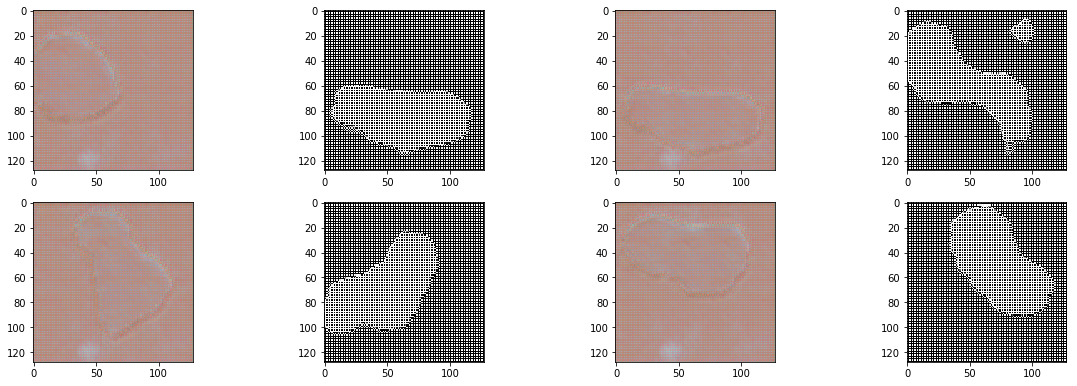

In [15]:
show_batch(df, path_gen + '/generated_images', path_gen + '/generated_masks')